# 불균형 데이터 처리

다음에서 코드르 가져와 이해하기 쉽게 코드를 수정하고 설명을 추가했다.

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ko




# 초기 준비

## 라이브러리 임포팅

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## matplot 관련

그림 크기를 설정하고, 이후 사용할 color값을 구해 놓는다

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 초기 설정

epoch, batch_size를 설정해 놓고, early stopping 컬백을 만드렁 둔다.

In [3]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 데이터 준비

## 데이터 로딩

In [4]:
# file = tf.keras.utils # TODO : remove
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 불균형 비

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print("pos =", pos)
print("neg =", neg)
print("pos ratio =", pos / (pos+neg) * 100)

pos = 492
neg = 284315
pos ratio = 0.1727485630620034


## 데이터 전처리

Time 컬럼 삭제

Amount의 값을 로그값으로 처리

In [6]:
cleaned_df = raw_df.copy()

# 'Time' 컬럼 삭제
cleaned_df.pop('Time')

# 'Amount'컬럼값에 log을 취해서 'Log Amount' 컬럼을 만든다.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

## 데이터 분리

In [7]:
# 전체를 8:2로 train, test로 나누고
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
# train을 다시 8:2로 train, validation으로 나눈다
train_df, val_df = train_test_split(train_df, test_size=0.2)

# 출력 lable
# 'Class'컬럼을 train_df에서 빼낸다.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

# 입력 features
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)
Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)


# Standardization

평균 0, 표준편차 1로 stradardization 실행

In [9]:
scaler = StandardScaler()

# 평균과 표준편차를 구해서 train 데이터에 적용
train_features = scaler.fit_transform(train_features)

# 구한 평균과 표준편차로 val, test 데치터에 적용
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# 최대 최소를 -5, 5로 제한
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

## 데이터 분포 보기

pos, neg 데이터 별로 컬럼 'V5', 'V6'를 2축으로 해서.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


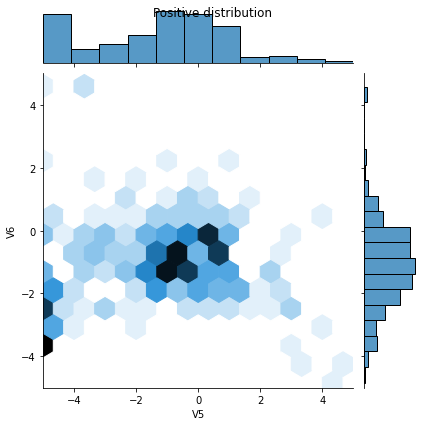

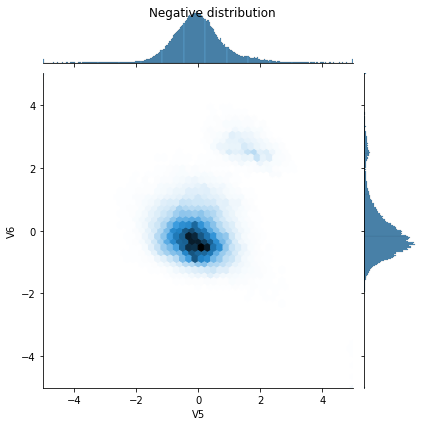

In [10]:
bool_train_labels = train_labels != 0

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

# 모델 정의

## metric 정의

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


*   FN(**False** Negative) 그리고 FP(**False** Positive)은 **잘못** 분류된 샘플.
*   TN(**True** Negative) 그리고 TP(**True** Positive)은 **제대로** 분류된 샘플.
*   **정확도**(accuracy) 는 전체 예측 중에 올바르게 예측한 비율입니다.
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **정밀도**(precision) 는 긍정으로 예측한 것 중에 올바르게 예측한 비율입니다.
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **재현율**(recall) 은 실제 긍정 중에 긍정으로 예측한 비율입니다.
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** 는 ROC(Receiver Operation Charateristic; 수신자 조작 특성) 곡선 아래 영역(ROC-AUC)을 나타냅니다.

참고: 정확도는 불균형한 데이터에서는 유용하지 않음. 항상 False 만 예측하는 모델도 불균형한 데이터에서는 아주 높은 정확도를 보일 수 있음.


## 모델 정의 함수

In [12]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

# 출력층 bias 초기값 처리

출력층의 bias 초기값을 다음으로 설정하면 학습 초기의 불필요한 학습을 방지할 수 있다. 혹은 학습 초기의 '하키 스틱' 로스를 피할 수 있다.

$$ b_0 = log_e(pos/neg)$$

http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines 문서의 **init well** 항목 참조

In [13]:
model = make_model()
results = model.evaluate(train_features, train_labels, verbose=0, batch_size=BATCH_SIZE)
print("loss =", results[0])

loss = 1.4273091554641724


In [14]:
initial_bias = np.log([pos/neg])
print(initial_bias)

[-6.35935934]


In [15]:
model = make_model(output_bias=initial_bias)
results = model.evaluate(train_features, train_labels, verbose=0, batch_size=BATCH_SIZE)
print("loss =", results[0])

loss = 0.016536135226488113


bias 설정 전에는 0.26, 설정 후에는 0.01의 loss를 보인다.

개선된 loss에서 학습을 시작한다.

## 학습 시의 차이 보기

In [16]:
model = make_model()
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


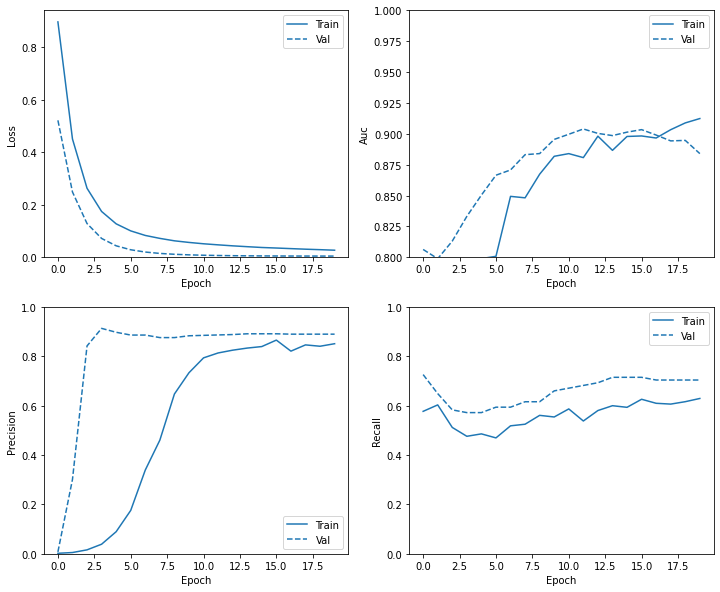

In [18]:
plot_metrics(zero_bias_history)

In [19]:
# model = make_model()
model = make_model(output_bias=initial_bias)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

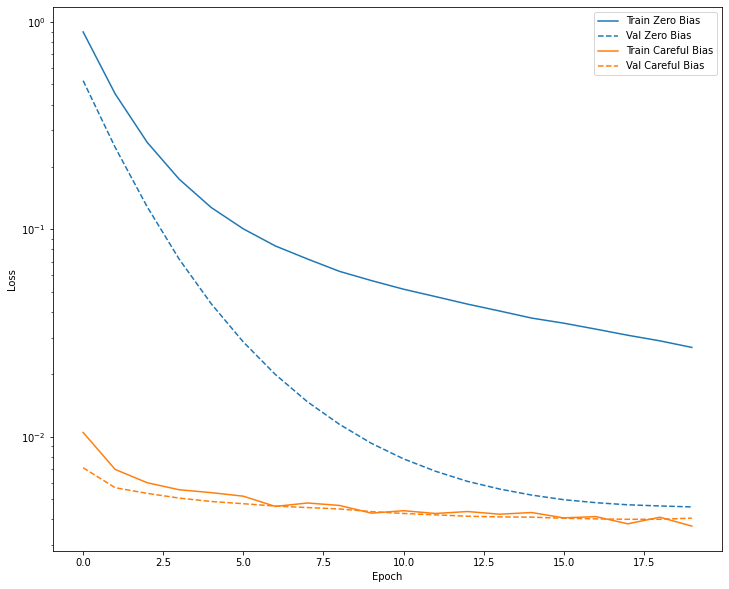

In [21]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

학습 초기 작은 loss에서 시작함을 볼 수 있다.

# 기반 모델

출력증 bias를 적용하고 데이터 불균형 관련 처리는 하지 않았다. 출력층 bias는 단지 초기 불필요한 학습을 줄여주는 역할만 한다.

## 학습

In [22]:
model = make_model(output_bias=initial_bias)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 4s 22ms/step - loss: 0.0114 - tp: 143.0000 - fp: 121.0000 - tn: 227326.0000 - fn: 255.0000 - accuracy: 0.9983 - precision: 0.5417 - recall: 0.3593 - auc: 0.8364 - val_loss: 0.0066 - val_tp: 33.0000 - val_fp: 6.0000 - val_tn: 45472.0000 - val_fn: 58.0000 - val_accuracy: 0.9986 - val_precision: 0.8462 - val_recall: 0.3626 - val_auc: 0.8928
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 0.0073 - tp: 129.0000 - fp: 35.0000 - tn: 181934.0000 - fn: 178.0000 - accuracy: 0.9988 - precision: 0.7866 - recall: 0.4202 - auc: 0.8964 - val_loss: 0.0056 - val_tp: 48.0000 - val_fp: 6.0000 - val_tn: 45472.0000 - val_fn: 43.0000 - val_accuracy: 0.9989 - val_precision: 0.8889 - val_recall: 0.5275 - val_auc: 0.9003
Epoch 3/100
90/90 [==============================] - 1s 12ms/step - loss: 0.0060 - tp: 148.0000 - fp: 34.0000 - tn: 181935.0000 - fn: 159.0000 - accuracy: 0.9989 - precision: 0.8132 - recall: 0.4821 - auc: 0.9214 - 

## metric 그리기

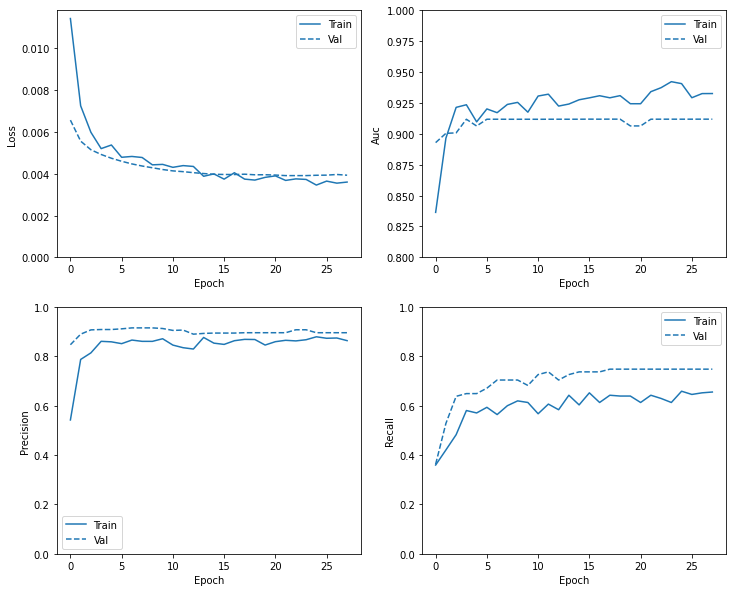

In [23]:
plot_metrics(baseline_history)

## 예측

In [24]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

## 평가

In [25]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0025664090644568205
tp :  75.0
fp :  10.0
tn :  56858.0
fn :  19.0
accuracy :  0.9994909167289734
precision :  0.8823529481887817
recall :  0.7978723645210266
auc :  0.9519020915031433

Legitimate Transactions Detected (True Negatives):  56858
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  75
Total Fraudulent Transactions:  94


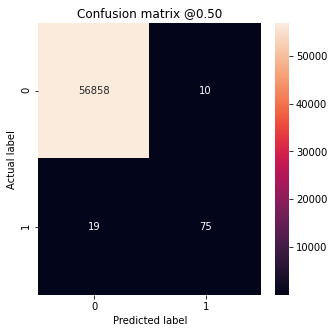

In [26]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

## ROC 그리기


In [27]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

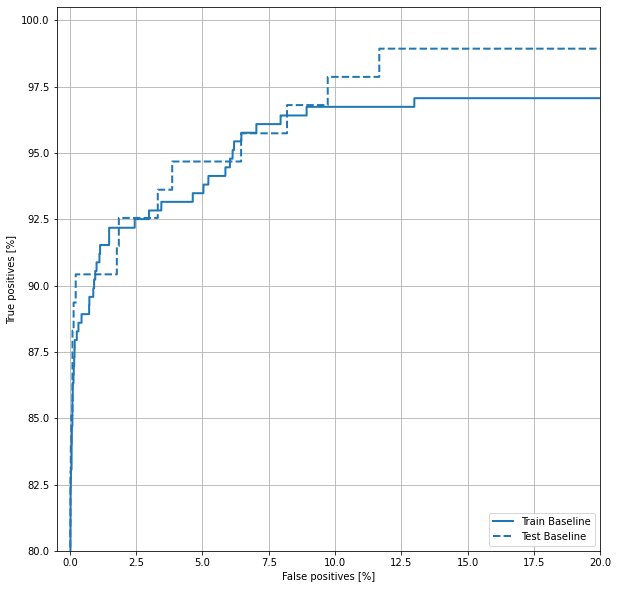

In [28]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

# 클래스별 가중치 적용

## 가중치 구하기

In [29]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


## 학습

In [30]:
weighted_model = make_model(output_bias=initial_bias)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
90/90 [==============================] - 4s 21ms/step - loss: 1.6694 - tp: 185.0000 - fp: 560.0000 - tn: 238277.0000 - fn: 216.0000 - accuracy: 0.9968 - precision: 0.2483 - recall: 0.4613 - auc: 0.8147 - val_loss: 0.0122 - val_tp: 51.0000 - val_fp: 48.0000 - val_tn: 45430.0000 - val_fn: 40.0000 - val_accuracy: 0.9981 - val_precision: 0.5152 - val_recall: 0.5604 - val_auc: 0.9214
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 0.7673 - tp: 193.0000 - fp: 1197.0000 - tn: 180772.0000 - fn: 114.0000 - accuracy: 0.9928 - precision: 0.1388 - recall: 0.6287 - auc: 0.8994 - val_loss: 0.0172 - val_tp: 65.0000 - val_fp: 89.0000 - val_tn: 45389.0000 - val_fn: 26.0000 - val_accuracy: 0.9975 - val_precision: 0.4221 - val_recall: 0.7143 - val_auc: 0.9341
Epoch 3/100
90/90 [==============================] - 1s 14ms/step - loss:

## metric 그리기

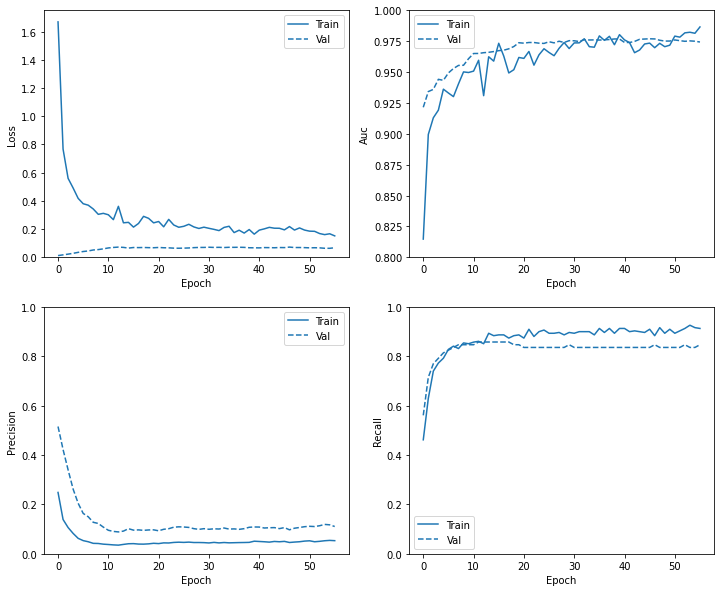

In [31]:
plot_metrics(weighted_history)

## 예측

In [32]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

## 평가

loss :  0.06939715147018433
tp :  86.0
fp :  776.0
tn :  56092.0
fn :  8.0
accuracy :  0.9862364530563354
precision :  0.09976798295974731
recall :  0.914893627166748
auc :  0.9936508536338806

Legitimate Transactions Detected (True Negatives):  56092
Legitimate Transactions Incorrectly Detected (False Positives):  776
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  94


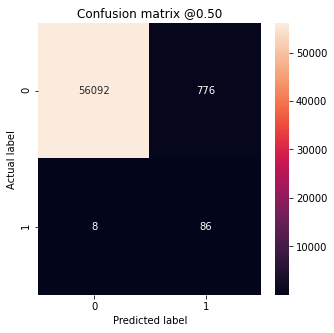

In [33]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

## ROC 그리기

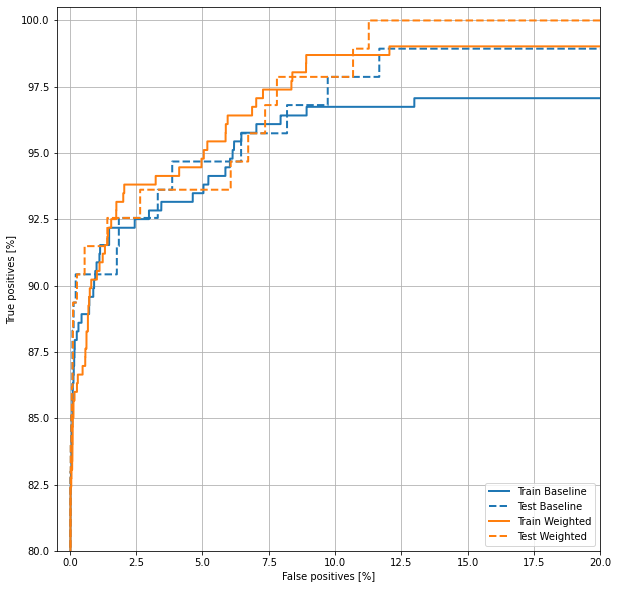

In [34]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

# 오버 샘플링

## 오버 샘플링 실행

In [35]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

neg가 잔뜩이고 pos가 작은 경우이다. 

neg의 갯수만큼 pos 데이터에서 샘플링한다.

In [36]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181969, 29)

In [37]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363938, 29)

## 학습

In [38]:
# model = make_model(output_bias=initial_bias)
resampled_model = make_model()

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
178/178 [==============================] - 5s 16ms/step - loss: 0.5260 - tp: 156627.0000 - fp: 74867.0000 - tn: 163970.0000 - fn: 25436.0000 - accuracy: 0.7617 - precision: 0.6766 - recall: 0.8603 - auc: 0.8897 - val_loss: 0.3727 - val_tp: 77.0000 - val_fp: 2413.0000 - val_tn: 43065.0000 - val_fn: 14.0000 - val_accuracy: 0.9467 - val_precision: 0.0309 - val_recall: 0.8462 - val_auc: 0.9464
Epoch 2/100
178/178 [==============================] - 2s 11ms/step - loss: 0.2507 - tp: 163216.0000 - fp: 14381.0000 - tn: 167588.0000 - fn: 18753.0000 - accuracy: 0.9090 - precision: 0.9190 - recall: 0.8969 - auc: 0.9634 - val_loss: 0.1812 - val_tp: 76.0000 - val_fp: 957.0000 - val_tn: 44521.0000 - val_fn: 15.0000 - val_accuracy: 0.9787 - val_precision: 0.0736 - val_recall: 0.8352 - val_auc: 0.9701
Epoch 3/100
178/178 [==============================] - 2s 12ms/step - loss: 0.1895 - tp: 165628.0000 - fp: 8833.0000 - tn: 173136.0000 - fn: 16341.0000 - accuracy: 0.9308 - precision: 0.9494 

## metric 그리기

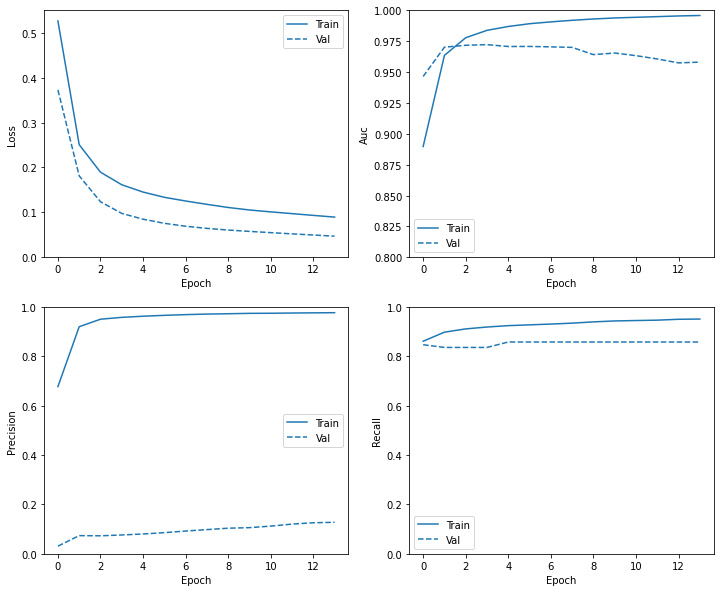

In [39]:
plot_metrics(resampled_history)

## 예측

In [40]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

## 평가

loss :  0.09722058475017548
tp :  88.0
fp :  1132.0
tn :  55736.0
fn :  6.0
accuracy :  0.9800217747688293
precision :  0.07213114947080612
recall :  0.936170220375061
auc :  0.990528404712677

Legitimate Transactions Detected (True Negatives):  55736
Legitimate Transactions Incorrectly Detected (False Positives):  1132
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  88
Total Fraudulent Transactions:  94


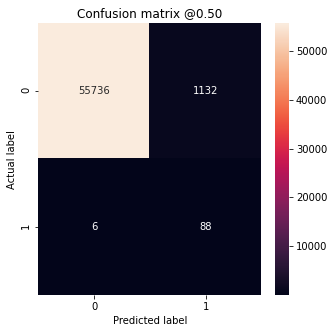

In [41]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

## ROC 그리기

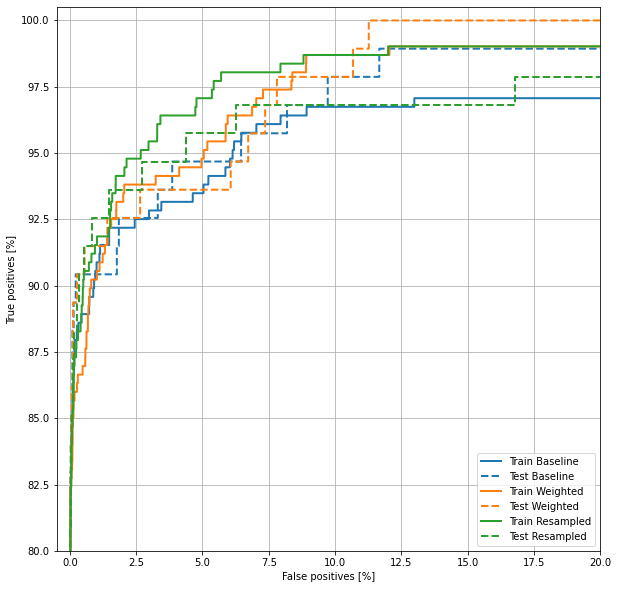

In [42]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')